# Credit Card Fraud Detection
### Recognize fraudulent credit card transactions
### 3.1 Undersampling
             KwangMyung Yu, Senior Researcher, Korea Electric Power Corporation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 30 #중요

In [2]:
color_pal = [ '#ee4035', '#3385c6', '#fed766','#eb6841', '#708090', 
	'#00a0b0', '#3b7dd8', '#fe4a49' , '#2ab7ca', '#851e3e', 
	'#2a4d69',  '#f7f7f7', '#edc951', '#54b2a9', '#ffffff', 
	'#96ceb4', '#ffeead', '#708090', '#be9b7b', '#feb2a8',
	'#58668b',  '#4f372d', '#ECD59F', '#ABD1DC', '#7E9680', 
    	'#E69D45', '#D4CFC9', '#E79796', '#C6C09C', '#dec3c3',
    	'#4b86b4', '#f9caa7', '#d2d4dc', '#ebf4f6', '#29a8ab' ]

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import recall_score,precision_score, accuracy_score
from sklearn.metrics import classification_report

In [4]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [5]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

In [6]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontsize = 16)
    plt.yticks(tick_marks, classes, fontsize = 16)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", 
                 fontsize = 18)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
data = pd.concat([X_train, y_train], axis = 1  )

In [8]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.960647,0.763452,0.842775,0.204318,0.758099,0.269866,0.257882,0.791613,0.375087,0.540551,0.286332,0.673156,0.476382,0.649411,0.373110,0.416167,0.763728,0.743389,0.796556,0.579968,0.562250,0.532742,0.666894,0.408700,0.523004,0.451754,0.419360,0.316008,0.349580,0
1,0.937487,0.778646,0.866046,0.291186,0.767456,0.262875,0.268479,0.785321,0.435766,0.515432,0.381947,0.718193,0.402575,0.664051,0.408625,0.429846,0.733673,0.662858,0.618587,0.578753,0.564805,0.533187,0.659784,0.415053,0.593216,0.393511,0.408617,0.315449,0.310746,0
2,0.960340,0.776268,0.835055,0.215063,0.771986,0.257684,0.271406,0.783793,0.462986,0.500200,0.176346,0.699338,0.474264,0.646769,0.310677,0.455800,0.708045,0.623882,0.587317,0.580266,0.556187,0.474999,0.664470,0.246617,0.558459,0.458498,0.421077,0.314890,0.081599,0
3,0.898383,0.739208,0.865208,0.281832,0.780090,0.270394,0.252593,0.801853,0.479653,0.489915,0.230392,0.703236,0.374951,0.655241,0.443471,0.422449,0.763751,0.551077,0.473866,0.589053,0.566507,0.508448,0.664071,0.159414,0.576510,0.509358,0.421699,0.304357,0.370188,0
4,0.978531,0.773099,0.827424,0.283306,0.768086,0.256350,0.266733,0.785073,0.448242,0.496593,0.410301,0.726836,0.429158,0.610367,0.375641,0.463916,0.762125,0.675296,0.529440,0.579260,0.560264,0.502385,0.664454,0.369370,0.604080,0.487764,0.416172,0.313715,0.055674,0


In [9]:
num_of_fraud = len(data[data['Class']==1]) #이상치의 개수
fraud_indices = np.array(data[data['Class']==1].index)
normal_indices = np.array(data[data['Class']==0].index)

In [10]:
random_normal_indices = np.random.choice(normal_indices, 
                        num_of_fraud, replace = False)
#np.random.choice(a, b, replace = False)
# a에서 b개의 element를 뽑아서 array로 리턴함.
# 이때 replace = False 이면 중복허용 안함

In [11]:
# 기존 indice와 랜덤 indice를 붙임, 그리고 데이터 인덱싱
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
under_sample_data = data.iloc[under_sample_indices,:]

In [12]:
print("Percentage of normal transactions: ", 
      len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", 
      len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: "
      , len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  688


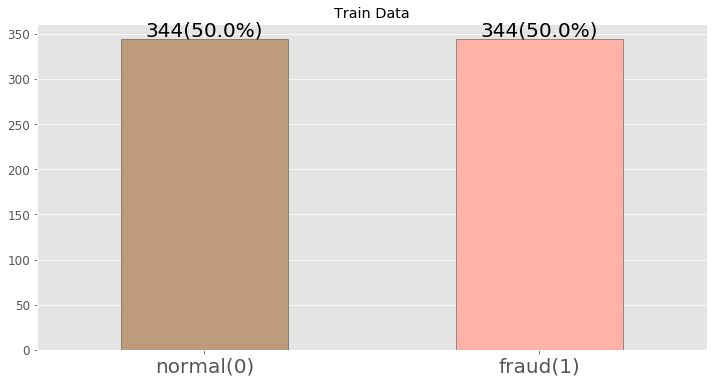

In [18]:
fig, ax = plt.subplots(figsize = (12, 6))
under_sample_data['Class'].value_counts().plot(kind = 'bar', color = color_pal[18:], 
                        edgecolor='#404040', ax = ax, fontsize = 12, rot = 0)

for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2., p.get_height()+4, 
            str(p.get_height())+'('+str(round((p.get_height()/under_sample_data.shape[0])*100,
            2))+ '%)', ha='center', fontsize = 20)

ax.set_title('Train Data')
ax.set_xticklabels(['normal(0)', 'fraud(1)'], fontsize = 20)
plt.show()

In [19]:
X_train = under_sample_data.drop('Class', axis = 1)
y_train = under_sample_data['Class']

#### Xgboost

In [20]:
XGB = XGBClassifier()
XGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

Test Result(Base_XGB)
accuracy :  0.9717940615381014
precsion : 0.05367008681925809
recall :  0.918918918918919


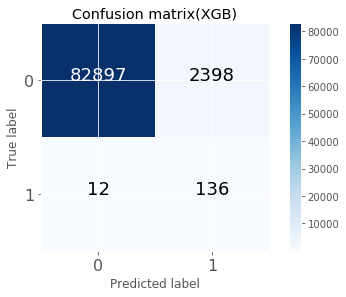

In [21]:
y_pred = XGB.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Test Result(Base_XGB)')
print('accuracy : ', acc)
print('precsion :', precision)
print('recall : ', recall)

class_names = [0,1]
plot_confusion_matrix(conf_mat , classes=class_names,
                      title='Confusion matrix(XGB)')
plt.show()

#### LGBM 

In [22]:
LGBM = LGBMClassifier()
LGBM.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Test Result(Base_LGBM)
accuracy :  0.9771894713434688
precsion : 0.06602409638554217
recall :  0.9256756756756757


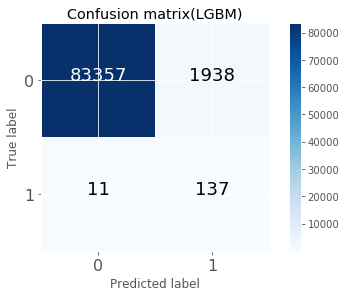

In [23]:
y_pred = LGBM.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Test Result(Base_LGBM)')
print('accuracy : ', acc)
print('precsion :', precision)
print('recall : ', recall)

class_names = [0,1]
plot_confusion_matrix(conf_mat , classes=class_names,
                      title='Confusion matrix(LGBM)')
plt.show()

#### CatBoost

In [24]:
Cat = CatBoostClassifier()
Cat.fit(X_train, y_train)

Learning rate set to 0.008782
0:	learn: 0.6809133	total: 64.4ms	remaining: 1m 4s
1:	learn: 0.6698092	total: 71ms	remaining: 35.4s
2:	learn: 0.6574401	total: 77.4ms	remaining: 25.7s
3:	learn: 0.6472748	total: 80.8ms	remaining: 20.1s
4:	learn: 0.6372540	total: 83.9ms	remaining: 16.7s
5:	learn: 0.6270536	total: 87.1ms	remaining: 14.4s
6:	learn: 0.6171304	total: 90.3ms	remaining: 12.8s
7:	learn: 0.6076848	total: 93.3ms	remaining: 11.6s
8:	learn: 0.5984085	total: 96.4ms	remaining: 10.6s
9:	learn: 0.5901323	total: 99.4ms	remaining: 9.84s
10:	learn: 0.5797673	total: 103ms	remaining: 9.22s
11:	learn: 0.5697770	total: 106ms	remaining: 8.69s
12:	learn: 0.5611067	total: 108ms	remaining: 8.2s
13:	learn: 0.5510344	total: 110ms	remaining: 7.76s
14:	learn: 0.5422961	total: 112ms	remaining: 7.37s
15:	learn: 0.5346983	total: 114ms	remaining: 7.03s
16:	learn: 0.5270435	total: 116ms	remaining: 6.73s
17:	learn: 0.5190789	total: 118ms	remaining: 6.45s
18:	learn: 0.5116917	total: 120ms	remaining: 6.2s
19:	l

206:	learn: 0.1228957	total: 513ms	remaining: 1.96s
207:	learn: 0.1225169	total: 515ms	remaining: 1.96s
208:	learn: 0.1220066	total: 518ms	remaining: 1.96s
209:	learn: 0.1216572	total: 520ms	remaining: 1.96s
210:	learn: 0.1211238	total: 523ms	remaining: 1.95s
211:	learn: 0.1206303	total: 525ms	remaining: 1.95s
212:	learn: 0.1200533	total: 527ms	remaining: 1.95s
213:	learn: 0.1194826	total: 530ms	remaining: 1.95s
214:	learn: 0.1188229	total: 532ms	remaining: 1.94s
215:	learn: 0.1183116	total: 535ms	remaining: 1.94s
216:	learn: 0.1178826	total: 537ms	remaining: 1.94s
217:	learn: 0.1175056	total: 539ms	remaining: 1.93s
218:	learn: 0.1171680	total: 541ms	remaining: 1.93s
219:	learn: 0.1168317	total: 543ms	remaining: 1.92s
220:	learn: 0.1163957	total: 545ms	remaining: 1.92s
221:	learn: 0.1157879	total: 547ms	remaining: 1.92s
222:	learn: 0.1154223	total: 548ms	remaining: 1.91s
223:	learn: 0.1148600	total: 550ms	remaining: 1.91s
224:	learn: 0.1145522	total: 552ms	remaining: 1.9s
225:	learn: 0

380:	learn: 0.0763428	total: 860ms	remaining: 1.4s
381:	learn: 0.0761659	total: 862ms	remaining: 1.39s
382:	learn: 0.0759761	total: 864ms	remaining: 1.39s
383:	learn: 0.0757681	total: 867ms	remaining: 1.39s
384:	learn: 0.0756737	total: 870ms	remaining: 1.39s
385:	learn: 0.0755220	total: 872ms	remaining: 1.39s
386:	learn: 0.0753398	total: 874ms	remaining: 1.38s
387:	learn: 0.0751411	total: 877ms	remaining: 1.38s
388:	learn: 0.0751184	total: 879ms	remaining: 1.38s
389:	learn: 0.0749993	total: 881ms	remaining: 1.38s
390:	learn: 0.0749183	total: 884ms	remaining: 1.38s
391:	learn: 0.0747409	total: 886ms	remaining: 1.37s
392:	learn: 0.0746465	total: 889ms	remaining: 1.37s
393:	learn: 0.0745336	total: 892ms	remaining: 1.37s
394:	learn: 0.0743549	total: 894ms	remaining: 1.37s
395:	learn: 0.0742420	total: 896ms	remaining: 1.37s
396:	learn: 0.0740477	total: 898ms	remaining: 1.36s
397:	learn: 0.0737076	total: 900ms	remaining: 1.36s
398:	learn: 0.0734876	total: 903ms	remaining: 1.36s
399:	learn: 0

612:	learn: 0.0517533	total: 1.37s	remaining: 867ms
613:	learn: 0.0516379	total: 1.38s	remaining: 865ms
614:	learn: 0.0516128	total: 1.38s	remaining: 863ms
615:	learn: 0.0515753	total: 1.38s	remaining: 861ms
616:	learn: 0.0515400	total: 1.38s	remaining: 859ms
617:	learn: 0.0515087	total: 1.39s	remaining: 857ms
618:	learn: 0.0514704	total: 1.39s	remaining: 855ms
619:	learn: 0.0513138	total: 1.39s	remaining: 853ms
620:	learn: 0.0512350	total: 1.39s	remaining: 851ms
621:	learn: 0.0511478	total: 1.4s	remaining: 849ms
622:	learn: 0.0510777	total: 1.4s	remaining: 847ms
623:	learn: 0.0510099	total: 1.4s	remaining: 845ms
624:	learn: 0.0508781	total: 1.4s	remaining: 842ms
625:	learn: 0.0508112	total: 1.41s	remaining: 840ms
626:	learn: 0.0507499	total: 1.41s	remaining: 837ms
627:	learn: 0.0507182	total: 1.41s	remaining: 835ms
628:	learn: 0.0506352	total: 1.41s	remaining: 833ms
629:	learn: 0.0506051	total: 1.41s	remaining: 831ms
630:	learn: 0.0505783	total: 1.42s	remaining: 829ms
631:	learn: 0.05

777:	learn: 0.0410955	total: 1.72s	remaining: 490ms
778:	learn: 0.0410742	total: 1.72s	remaining: 488ms
779:	learn: 0.0410517	total: 1.72s	remaining: 486ms
780:	learn: 0.0409573	total: 1.72s	remaining: 483ms
781:	learn: 0.0409434	total: 1.73s	remaining: 481ms
782:	learn: 0.0409284	total: 1.73s	remaining: 479ms
783:	learn: 0.0408426	total: 1.73s	remaining: 477ms
784:	learn: 0.0407250	total: 1.73s	remaining: 475ms
785:	learn: 0.0406290	total: 1.74s	remaining: 473ms
786:	learn: 0.0405104	total: 1.74s	remaining: 470ms
787:	learn: 0.0404530	total: 1.74s	remaining: 468ms
788:	learn: 0.0404311	total: 1.74s	remaining: 466ms
789:	learn: 0.0403086	total: 1.74s	remaining: 464ms
790:	learn: 0.0402744	total: 1.75s	remaining: 461ms
791:	learn: 0.0402028	total: 1.75s	remaining: 459ms
792:	learn: 0.0401771	total: 1.75s	remaining: 457ms
793:	learn: 0.0401350	total: 1.75s	remaining: 455ms
794:	learn: 0.0400502	total: 1.75s	remaining: 452ms
795:	learn: 0.0400339	total: 1.76s	remaining: 450ms
796:	learn: 

947:	learn: 0.0330095	total: 2.06s	remaining: 113ms
948:	learn: 0.0329986	total: 2.06s	remaining: 111ms
949:	learn: 0.0329867	total: 2.07s	remaining: 109ms
950:	learn: 0.0329544	total: 2.07s	remaining: 107ms
951:	learn: 0.0328127	total: 2.07s	remaining: 104ms
952:	learn: 0.0327784	total: 2.07s	remaining: 102ms
953:	learn: 0.0327508	total: 2.08s	remaining: 100ms
954:	learn: 0.0327220	total: 2.08s	remaining: 98ms
955:	learn: 0.0327092	total: 2.08s	remaining: 95.8ms
956:	learn: 0.0326982	total: 2.08s	remaining: 93.6ms
957:	learn: 0.0325646	total: 2.08s	remaining: 91.4ms
958:	learn: 0.0325543	total: 2.09s	remaining: 89.3ms
959:	learn: 0.0324588	total: 2.09s	remaining: 87.1ms
960:	learn: 0.0324295	total: 2.09s	remaining: 84.9ms
961:	learn: 0.0323479	total: 2.09s	remaining: 82.7ms
962:	learn: 0.0323384	total: 2.1s	remaining: 80.6ms
963:	learn: 0.0323278	total: 2.1s	remaining: 78.4ms
964:	learn: 0.0323114	total: 2.1s	remaining: 76.2ms
965:	learn: 0.0322850	total: 2.1s	remaining: 74.1ms
966:	l

Test Result(Base_Cat)
accuracy :  0.9838254742928034
precsion : 0.08976063829787234
recall :  0.9121621621621622


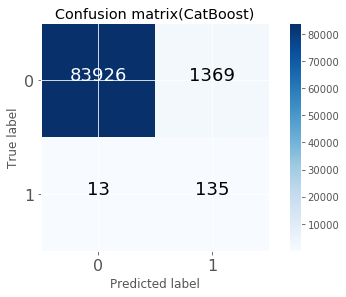

In [25]:
y_pred = Cat.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print('Test Result(Base_Cat)')
print('accuracy : ', acc)
print('precsion :', precision)
print('recall : ', recall)

class_names = [0,1]
plot_confusion_matrix(conf_mat , classes=class_names,
                      title='Confusion matrix(CatBoost)')
plt.show()